In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import pandas as pd

ratings = pd.read_csv("ratings.csv", sep='\t', encoding='latin-1',
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

movies = pd.read_csv("movies.csv", sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [61]:
actual_movies = pd.read_csv("movies.csv", sep='\t', encoding='latin-1',
                     usecols=['movie_id', 'title', 'genres'])

In [3]:
movies.head(5)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354


### Content Based

**Objective**: Build a Content-Based Recommendation system that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre.

**Dataset**:
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Split the `genres` column into separate genre strings.
   - Fill any missing values in the `genres` column and convert it to string.

2. **Compute TF-IDF Matrix**:
   - Use `TfidfVectorizer` to transform the genres into a TF-IDF matrix.

3. **Calculate Cosine Similarity**:
   - Compute cosine similarity between the TF-IDF matrices of movies.

4. **Recommend Movies**:
   - Create a function that gets movie recommendations based on the cosine similarity score of movie genres.

In [5]:
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].fillna("").astype('str')

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])

In [9]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [125]:
def genre_recommendations(title, n=10):
    idx = None 
    for i,value in enumerate(movies['title']) :
        if value == title : 
            idx = i
            break 
    if idx == None : 
        assert('AttributeError') 
    A = []
    for i,value in enumerate(cosine_sim[idx]) : 
         A.append((i,value))
    
    sorted_cosine_sim = sorted(A, key=lambda x: x[1], reverse=True)[0:n+1]
    movie_ids = [x[0] for x in sorted_cosine_sim]
    for movie_id in movie_ids : 
        if movie_id == idx : 
            movie_ids.remove(idx)
            
    return movies['title'].iloc[movie_ids]


In [126]:
genre_recommendations('GoldenEye (1995)')

345     Clear and Present Danger (1994)
543           Surviving the Game (1994)
724                    Rock, The (1996)
788                     Daylight (1996)
825               Chain Reaction (1996)
978                 Maximum Risk (1996)
1467                    Anaconda (1997)
1513                     Con Air (1997)
1693                   Firestorm (1998)
3686          Perfect Storm, The (2000)
Name: title, dtype: object


### Collaborative Filtering

**Objective**: Implement a collaborative filtering movie recommendation system to recommend movies to a user based on similar users' spreferences.

**Dataset**:

- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Split `genres` column into separate rows.

2. **Create User-Genre Matrix**:
   - Create a matrix where rows are users and columns are genres.
   - Each cell represents the ratio of movies watched by the user in that genre to the total movies watched by the user.

3. **Calculate User Similarity**:
   - Use cosine similarity to calculate the similarity between users.

4. **Find Top N Similar Users**:
   - Find the top N users with the most similar preferences to the given user.

5. **Recommend Movies**:
   - Recommend movies that similar users have watched but the target user has not.
   - Return titles and genres of the top 10 recommended movies.

In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [24]:
data = pd.merge(ratings, movies, on='movie_id')

In [25]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']


In [26]:
data = data.assign(genres=data['genres'].str.split('|')).explode('genres')

In [27]:
data.head(5)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,1,1193,5,0,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
1,2,1193,5,1,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
2,12,1193,4,11,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
3,15,1193,4,14,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']
4,17,1193,5,16,1192,One Flew Over the Cuckoo's Nest (1975),['Drama']


In [72]:
movie_idxs = {}
for i,value in enumerate(actual_movies['movie_id']) : 
    movie_idxs[value] = i

In [73]:
user_genre_dict = {}
for i in range(len(data)) : 
    sample_user_id = data['user_id'][i]
    movie_id = data['movie_id'][i]
    #print(actual_movies['genres'][movie_id])
    idx = movie_idxs[movie_id]

    sample_genres = actual_movies['genres'][idx].split('|')
    #print(sample_genres[0])
    for genre in sample_genres :
        if sample_user_id not in user_genre_dict : 
            user_genre_dict[sample_user_id] = {}
        if genre not in user_genre_dict[sample_user_id] : 
            user_genre_dict[sample_user_id][genre] = 0
        user_genre_dict[sample_user_id][genre] += 1

In [123]:
UG_matrix = pd.DataFrame(user_genre_dict)
UG_matrix = UG_matrix.T
UG_matrix = UG_matrix.replace(np.nan,0)
user_sim = cosine_similarity(UG_matrix,UG_matrix)
index_user_id = {}
user_id_index = {}
for i,user_id in enumerate(UG_matrix.index) : 
    index_user_id[user_id] = i
    user_id_index[i] = user_id

In [131]:
def get_top_n_similar_users(user_id, n=5):
    idx = index_user_id[user_id]
    arr = []
    for i,value in enumerate(user_sim[idx]) : 
        arr.append((i,value))
    arr = sorted(arr, key=lambda x:x[1], reverse=True)[0:n+1]
    arr = [x[0] for x in arr]
    arr.remove(idx)
    arr = [user_id_index[x] for x in arr]
    return arr 

In [152]:
def recommend_movies(user_id, n_similar_users=5, n_recommendations=10):
    sim_users = get_top_n_similar_users(user_id, n_similar_users)
    sim_data = data[data['user_id'].isin(sim_users)]
    count_data = {}
    for movie_id in actual_movies['movie_id'] : 
        count_data[movie_id] = 0
    for movie_id in sim_data['movie_id'] : 
        count_data[movie_id] += 1 
    
    recommend = []
    non_recomend = []
    for i,movie_id in enumerate(data['movie_id']) : 
        if data['user_id'][i] == user_id : 
            non_recomend.append(movie_id) 
        recommend.append(movie_id)
    non_recomend = np.unique(np.array(non_recomend))
    for movie_id in non_recomend : 
        recommend.remove(movie_id) 
    recommend = np.unique(np.array(recommend))
    new_recommend = []
    for movie_id in recommend : 
        new_recommend.append((movie_id,count_data[movie_id]))
    
    new_recommend = sorted(new_recommend, key=lambda x:x[1], reverse=True)[0:n_recommendations]
  #  print(new_recommend)
    output = {}
    for x in new_recommend : 
        movie_id = x[0]
        idx = movie_idxs[movie_id]
        output[movie_id] = {'title': actual_movies['title'][idx], 'genres': actual_movies['genres'][idx]}
    output = pd.DataFrame(output).T
    return output
    

In [153]:
# Example
user_id = 1
recommended_movies = recommend_movies(user_id, n_similar_users=5, n_recommendations=10)

In [154]:
recommended_movies

,title,genres
595,Beauty and the Beast (1991),Animation|Children's|Musical
1022,Cinderella (1950),Animation|Children's|Musical
1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi
588,Aladdin (1992),Animation|Children's|Comedy|Musical
1032,Alice in Wonderland (1951),Animation|Children's|Musical
2028,Saving Private Ryan (1998),Action|Drama|War
2080,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
2081,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance
2096,Sleeping Beauty (1959),Animation|Children's|Musical
2355,"Bug's Life, A (1998)",Animation|Children's|Comedy


### SVD (Singular Value Decomposition)



**Objective**: Implement an SVD-based recommendation system to recommend movies to users by decomposing the user-item interaction matrix into latent factors.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Preprocess Data**:
   - Merge `ratings` and `movies` DataFrames on `movie_id`.
   - Create a user-item matrix where rows represent users, columns represent movies, and the values are the ratings.

2. **Decompose Matrix using SVD**:
   - Apply Singular Value Decomposition (SVD) to decompose the user-item matrix into three matrices: $U$, $\Sigma$, and $V^T$.

3. **Reconstruct Matrix**:
   - Reconstruct the user-item matrix using the top $k$ singular values to reduce dimensionality.

4. **Predict Ratings**:
   - Use the reconstructed matrix to predict ratings for all user-item pairs.

5. **Recommend Movies**:
   - Recommend the top 20 movies with the highest predicted ratings for a given user that the user hasn't rated yet.

In [155]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Fill na elements.

In [289]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').replace(np.nan,0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(np.array(Ratings))
sigma = np.diag(sigma)

In [190]:
U.shape

(6040, 6)

In [191]:
sigma.shape

(6, 6)

In [192]:
Vt.shape

(6, 3706)

In [198]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

In [199]:
preds = pd.DataFrame(all_user_predicted_ratings, columns=Ratings.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,1.751824,0.244750,0.211983,0.056873,0.174201,-0.326069,0.404085,0.043138,-0.064721,0.109654,...,-0.007240,0.004549,0.015544,-0.022484,-0.044613,0.331933,-0.075635,-0.029093,0.000664,0.009474
1,1.153659,0.255958,0.229254,0.071094,0.173009,1.287328,0.461180,0.014616,0.097666,1.087260,...,-0.024573,-0.000209,-0.008717,0.032181,0.005380,0.394876,-0.053244,0.013948,-0.010201,0.297717
2,1.354922,0.299652,0.143961,-0.001171,0.091686,0.073186,0.184797,0.031427,-0.004350,0.390588,...,-0.008286,0.000969,0.014029,-0.003212,-0.024541,0.262025,-0.048164,-0.017725,-0.009393,0.003943
3,0.417658,0.069586,-0.054706,-0.081009,-0.081361,0.283636,-0.103626,-0.003552,0.011544,0.316175,...,-0.014353,-0.002609,0.001458,-0.001538,0.001381,0.017702,-0.068074,-0.008331,-0.014550,-0.007269
4,1.168469,-0.092868,0.039106,0.091556,-0.047282,1.147452,-0.070903,-0.007414,-0.007180,-0.030491,...,0.182007,0.003311,0.003029,0.070499,0.045870,1.086469,0.867472,0.110370,0.100399,0.689873


In [281]:
import pandas as pd

def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):

      user_row_number = userID - 1 # User ID starts at 1, not 0
      sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False)
      
      user_rate_data = original_ratings[original_ratings.user_id == userID]
      already_rated_movies = np.unique(np.array(user_rate_data['movie_id']))

      print(f'User {userID} has already rated {len(already_rated_movies)} movies.')
      print(f'Recommending highest {num_recommendations} predicted ratings movies not already rated.')

      recommends = movies[movies['movie_id'].isin(list(already_rated_movies))]
      sorted_recommends = []
      for movie_id in recommends['movie_id'] : 
            sorted_recommends.append((movie_id,sorted_user_predictions[movie_id]))
      sorted_recommends = sorted(sorted_recommends, key=lambda x:x[1], reverse=True)[0:num_recommendations]
      output_recommend = [{'movie_id' : movies['movie_id'][movie_idxs[movie_id[0]]],
                           'genres' : movies['genres'][movie_idxs[movie_id[0]]],
                           'title' : movies['title'][movie_idxs[movie_id[0]]]} 
                          for movie_id in sorted_recommends]
      
      output_already_rated = user_rate_data.sort_values(['rating'], ascending=False)
      output_already_rated = output_already_rated.merge(movies, on='movie_id')
      output_recommend = pd.DataFrame(output_recommend)
      return output_already_rated, output_recommend

In [282]:
already_rated, predictions = recommend_movies(preds, 4375, movies, ratings, 20)

User 4375 has already rated 325 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [283]:
ratings.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
5,1,1197,3,0,1196
6,1,1287,5,0,1286
7,1,2804,5,0,2803
8,1,594,4,0,593
9,1,919,4,0,918


In [285]:
# Top 20 movies that User 4375 has rated
already_rated.head(20)

,user_id,movie_id,rating,user_emb_id,movie_emb_id,title,genres
0,4375,3250,5,4374,3249,Alive (1993),['Drama']
1,4375,175,5,4374,174,Kids (1995),['Drama']
2,4375,3257,5,4374,3256,"Bodyguard, The (1992)","['Action', 'Drama', 'Romance', 'Thriller']"
3,4375,3809,5,4374,3808,What About Bob? (1991),['Comedy']
4,4375,2688,5,4374,2687,"General's Daughter, The (1999)","['Drama', 'Thriller']"
5,4375,150,5,4374,149,Apollo 13 (1995),['Drama']
6,4375,2710,5,4374,2709,"Blair Witch Project, The (1999)",['Horror']
7,4375,349,5,4374,348,Clear and Present Danger (1994),"['Action', 'Adventure', 'Thriller']"
8,4375,288,5,4374,287,Natural Born Killers (1994),"['Action', 'Thriller']"
9,4375,47,5,4374,46,Seven (Se7en) (1995),"['Crime', 'Thriller']"


#### Evaluation

In [298]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

train_data, test_data = train_test_split(ratings, test_size=0.25, shuffle=True)

train_ratings = train_data.pivot(index='user_id', columns='movie_id', values='rating').replace(np.nan,0)
R_train = train_ratings.values
user_ratings_mean_train = np.mean(R_train,axis=1)
Ratings_demeaned_train = R_train - user_ratings_mean_train.reshape(-1, 1)

U_train, sigma_train, Vt_train = svds(np.array(train_ratings))
sigma_train = np.diag(sigma_train)

all_user_predicted_ratings_train = np.dot(np.dot(U_train, sigma_train), Vt_train) + user_ratings_mean_train.reshape(-1,1)
preds_train = pd.DataFrame(all_user_predicted_ratings_train, columns=train_ratings.columns)

def predict_rating(user_id, movie_id):
    #print(user_id, movie_id)
    try : 
        return preds_train.loc[user_id-1, movie_id]
    except :   
        return None
test_data['predicted_rating'] = test_data.apply(lambda x: predict_rating(x['user_id'], x['movie_id']), axis=1)

test_data.dropna(inplace=True)

rmse = sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 2.682420605220229


### Nueral Network Model (Recommender Model)



**Objective**: Implement a Recommender model to recommend movies to a user based on similar users' preferences.

**Dataset**:
- **Ratings Data**: DataFrame with columns `user_id`, `movie_id`, and `rating`.
- **Movies Data**: DataFrame with columns `movie_id`, `title`, and `genres`.

**Steps**:

1. **Define Dataset and DataLoader**:
   - Create a custom PyTorch `Dataset` for ratings.
   - Create a DataLoader for batching and shuffling data.

2. **Define the Neural Network**:
   - Create a neural network with embedding layers for users and movies.

3. **Train the Model**:
   - Train the model using Mean Squared Error loss and Adam optimizer.
   - Save model checkpoints.

4. **Evaluate the Model**:
   - Calculate RMSE on the entire dataset.

5. **Predict Ratings for Unrated Movies**:
   - Predict and recommend top 10 unrated movies for a given user.

In [301]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

In [314]:
# Define the dataset
class RatingsDataset(Dataset):
    def __init__(self, ratings):
        self.rates = ratings['rating'].values
        self.users = ratings['user_id'].values
        self.movies = ratings['movie_id'].values
        pass

    def __len__(self):
        return len(self.rates)

    def __getitem__(self, idx):
        return (torch.tensor(self.users[idx], dtype=torch.long),
                torch.tensor(self.movies[idx], dtype=torch.long),
                torch.tensor(self.rates[idx], dtype=torch.float))

# Define the neural network
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=50):
        super(RecommenderNet, self).__init__()
        super().__init__()
        self.user_embeder = nn.Embedding(num_users, embedding_size)
        self.movie_embeder = nn.Embedding(num_movies, embedding_size)
        self.network = nn.Sequential(
            nn.Linear(embedding_size * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, user, movie):
        user_embedded = self.user_embeder(user)
        movie_embedded = self.movie_embeder(movie)
        concatenated = torch.cat((user_embedded, movie_embedded), dim=1)
        output = self.network(concatenated)
        return output

# Create the dataset and dataloader
train_data, test_data = train_test_split(ratings, test_size=0.25, shuffle=True)
train_ratings_dataset = RatingsDataset(train_data)
test_ratings_dataset = RatingsDataset(test_data)
train_dataloader = DataLoader(train_ratings_dataset, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(test_ratings_dataset, batch_size=1000, shuffle=True)

# Initialize the model, loss function and optimizer
number_of_users = max(ratings['user_id'])
number_of_movies = max(ratings['movie_id'])
model = RecommenderNet(number_of_users + 5, number_of_movies + 5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0125)

# Training loop
num_epochs = 8
train_loss = None
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    print('------------------------------------------------')
    print('current epoch :', epoch)
    for user, movie, rate in tqdm.tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = model(user, movie)
        loss = criterion(outputs, rate.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

# Evaluation
model.eval()
val_loss = 0.0
with torch.no_grad():
    for user, movie, rate in test_dataloader:
        outputs = model(user, movie)
        outputs = outputs.squeeze()
        loss = criterion(outputs, rate.float())
        val_loss += loss.item()
val_loss /= len(test_dataloader)

print('train loss :', train_loss)
print('test loss :', val_loss)

------------------------------------------------
current epoch : 0


  0%|          | 0/751 [00:00<?, ?it/s]c:\Users\sazegar\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|█████████▉| 748/751 [00:22<00:00, 36.96it/s]c:\Users\sazegar\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([156])) that is different to the input size (torch.Size([156, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 751/751 [00:22<00:00, 32.76it/s]


------------------------------------------------
current epoch : 1


100%|██████████| 751/751 [00:22<00:00, 33.50it/s]


------------------------------------------------
current epoch : 2


100%|██████████| 751/751 [00:23<00:00, 32.11it/s]


------------------------------------------------
current epoch : 3


100%|██████████| 751/751 [00:21<00:00, 34.21it/s]


------------------------------------------------
current epoch : 4


100%|██████████| 751/751 [00:21<00:00, 34.89it/s]


------------------------------------------------
current epoch : 5


100%|██████████| 751/751 [00:21<00:00, 34.37it/s]


------------------------------------------------
current epoch : 6


100%|██████████| 751/751 [00:32<00:00, 23.33it/s]


------------------------------------------------
current epoch : 7


100%|██████████| 751/751 [00:30<00:00, 24.80it/s]


train loss : 1.2521740148927814
test loss : 1.2490786952801434


In [315]:
# Example

sample_user_id = 1
sample_user_data = ratings[ratings['user_id'] == sample_user_id]
sample_dataset = RatingsDataset(sample_user_data)
sample_dataloader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(f'Sample predictions for user ID {sample_user_id}:')
with torch.no_grad():
    for user, movie, rating in sample_dataloader:
        output = model(user, movie).squeeze()
        print(f'Movie ID: {movie.item()}, Predicted Rating: {output.item()}, Actual Rating: {rating.item()}')

Sample predictions for user ID 1:
Movie ID: 1193, Predicted Rating: 3.6420536041259766, Actual Rating: 5.0
Movie ID: 661, Predicted Rating: 3.6274726390838623, Actual Rating: 3.0
Movie ID: 914, Predicted Rating: 3.6228432655334473, Actual Rating: 3.0
Movie ID: 3408, Predicted Rating: 3.626328706741333, Actual Rating: 4.0
Movie ID: 2355, Predicted Rating: 3.6433749198913574, Actual Rating: 5.0
Movie ID: 1197, Predicted Rating: 3.6637659072875977, Actual Rating: 3.0
Movie ID: 1287, Predicted Rating: 3.690789222717285, Actual Rating: 5.0
Movie ID: 2804, Predicted Rating: 3.6621475219726562, Actual Rating: 5.0
Movie ID: 594, Predicted Rating: 3.6484146118164062, Actual Rating: 4.0
Movie ID: 919, Predicted Rating: 3.6654181480407715, Actual Rating: 4.0
Movie ID: 595, Predicted Rating: 3.6427114009857178, Actual Rating: 5.0
Movie ID: 938, Predicted Rating: 3.652566432952881, Actual Rating: 4.0
Movie ID: 2398, Predicted Rating: 3.6403656005859375, Actual Rating: 4.0
Movie ID: 2918, Predicted 

In [318]:
def predict_unrated_movies(user_id, model, ratings, movies):
    user_id = user_id - 1
    all_movies = np.unique(np.array(movies['movie_id']))
    movies_with_rate = np.unique(np.array(ratings[ratings['user_id'] == user_id]['movie_id']))
    movies_without_rate = []
    for x in all_movies       : movies_without_rate.append(x) 
    for x in movies_with_rate : movies_without_rate.remove(x)
    movies_without_rate = np.array(movies_without_rate)
    number_of_movies_without_rate = len(movies_without_rate)
    torch_users = torch.tensor([user_id] * number_of_movies_without_rate, dtype=torch.long)
    torch_movies = torch.tensor(movies_without_rate, dtype=torch.long)

    model.eval()
    with torch.no_grad():
        pred = model(torch_users, torch_movies).numpy()
    recommend_movies = []
    for i in range(len(pred)) : 
        recommend_movies.append((movies_without_rate[i], pred[i])) 
    recommend_movies = sorted(recommend_movies, key=lambda x:x[1], reverse=True)[0:10]
    index = {}
    for i,value in enumerate(movies['movie_id']) : 
        index[value] = i 

    recommend_df = []
    for movie_id,score in recommend_movies : 
        sample = {}
        idx = index[movie_id]
        sample['movie_id'] = movie_id
        sample['title'] = movies['title'][idx]
        sample['genres'] = movies['genres'][idx]
        sample['predicted_rating'] = score
        recommend_df.append(sample)
    recommend_df = pd.DataFrame(recommend_df)   
    return recommend_df

# Example
user_id = 1
predictions = predict_unrated_movies(user_id, model, ratings, movies)
predictions

,movie_id,title,genres,predicted_rating
0,1122,Plutonium Circus (1995),['Documentary'],[3.903339]
1,3237,Kestrel's Eye (Falkens öga) (1998),['Documentary'],[3.8752775]
2,2592,"Joyriders, The (1999)",['Drama'],[3.855548]
3,820,"Death in the Garden (Mort en ce jardin, La) (1...",['Drama'],[3.8474684]
4,768,Someone Else's America (1995),['Drama'],[3.845253]
5,1830,Follow the Bitch (1998),['Comedy'],[3.8420963]
6,2602,Mighty Peking Man (Hsing hsing wang) (1977),"['Adventure', 'Sci-Fi']",[3.834722]
7,641,"Little Indian, Big City (Un indien dans la vil...",['Comedy'],[3.8307552]
8,1528,Intimate Relations (1996),['Comedy'],[3.827909]
9,3583,Black Tights (Les Collants Noirs) (1960),['Drama'],[3.8264656]


### GMM (Gaussian Mixture Model)

**Objective**: Use a Gaussian Mixture Model to analyze and cluster the click data based on the number of clicks from different locations, aiming to identify distinct patterns of user behavior across 10 countries.

**Dataset**:
- **Click Data**: DataFrame with columns `link_id`, `location`, and `number_of_clicks`.

**Steps**:

1. **Preprocess Data**:
   - Ensure the dataset contains 10 distinct countries.
   - Create a matrix where rows represent different links and columns represent the number of clicks from each country.
   - Normalize the number of clicks to account for different scales.

2. **Fit GMM**:
   - Apply a Gaussian Mixture Model (GMM) to the click data matrix to identify clusters of links with similar click patterns across different countries.

3. **Evaluate Model**:
   - Analyze the resulting model by calculating the log lokelihood, BIC and AIC metrics.


number of counteries : 10


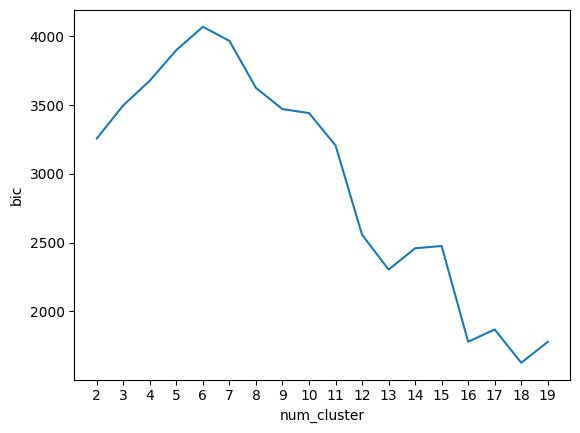

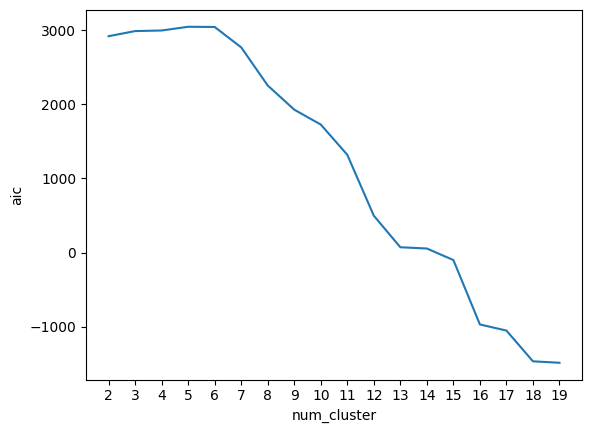

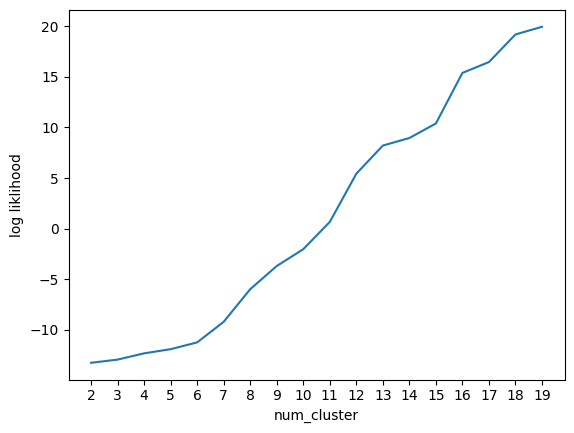

I choosed n_clusters = 11
Log-Likelihood: 2.2295245948529376
BIC: 2892.8434658707793
AIC: 1004.0950810294125


In [405]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data = pd.read_csv('gmm-dataset.csv')
click_data_per_country = np.array(data.drop('URL',axis=1))
scaler = StandardScaler()
normalized_click_data = scaler.fit_transform(click_data_per_country)
number_of_counteries = click_data_per_country.shape[1]
print('number of counteries :', number_of_counteries)

arr_k = []
arr_log_liklihood = []
arr_bic = []
arr_aic = []
for k in range(2,20) : 
    num_clusters = 11
    GMM_model = GaussianMixture(n_components=k)
    GMM_model.fit(normalized_click_data)

    log_likelihood = GMM_model.score(normalized_click_data)
    bic = GMM_model.bic(normalized_click_data)
    aic = GMM_model.aic(normalized_click_data)
    arr_k.append(k)
    arr_aic.append(aic)
    arr_bic.append(bic)
    arr_log_liklihood.append(log_likelihood)

plt.plot(arr_k, arr_bic, )
plt.xticks(arr_k)
plt.xlabel("num_cluster")
plt.ylabel("bic")
plt.show()

plt.plot(arr_k, arr_aic)
plt.xticks(arr_k)
plt.xlabel("num_cluster")
plt.ylabel("aic")
plt.show()

plt.plot(arr_k, arr_log_liklihood)
plt.xticks(arr_k)
plt.xlabel("num_cluster")
plt.ylabel("log liklihood")
plt.show()

num_clusters = 11
print('I choosed n_clusters =', num_clusters)
GMM_model = GaussianMixture(n_components=num_clusters)
GMM_model.fit(normalized_click_data)

log_likelihood = GMM_model.score(normalized_click_data)
bic = GMM_model.bic(normalized_click_data)
aic = GMM_model.aic(normalized_click_data)

print(f"Log-Likelihood: {log_likelihood}")
print(f"BIC: {bic}")
print(f"AIC: {aic}")